# Encoding Analysis
Converting input data to spike trains.

### Import libraries

In [1]:
import os
from itertools import product

import numpy as np
import pandas as pd
import scipy as sp
from scipy.signal import firwin
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from neucube.encoding import StepForward, BensSpikerAlgorithm, ThresholdBasedRepresentation, MovingWindow
from neucube import NeuCube

### Load Dataset

In [2]:
project = 'wrist_movement_eeg'

In [3]:
# dataset = []
# labels = []
# DIR = os.path.join('data', 'raw', project)
# for filename in os.listdir(DIR):
#     if filename[:3]=='s# am':
#         sample = pd.read_csv(os.path.join(DIR, filename), header=None).v# alues
#         dataset.append(sample)
# dataset = np.array(dataset)
# labels = pd.read_csv(os.path.join(DIR, 'tar_class_labels.csv'), header=None).values.flatten()-1
# dataset.shape, labels.shape

In [4]:
# np.save(os.path.join('data', 'processed', project+'_data'), dataset)
# np.save(os.path.join('data', 'processed', project+'_labels'), labels)

In [8]:
feature_names = pd.read_csv(os.path.join('data', 'raw', project, 'feature_names.txt'), delimiter = "\n", header=None).values.flatten()
feature_names

array(['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8',
       'FC6', 'F4', 'F8', 'AF4'], dtype=object)

In [9]:
dataset = np.load(os.path.join('data', 'processed', project+'_data.npy'))
labels = np.load(os.path.join('data', 'processed', project+'_labels.npy'))

Scaling the data

In [10]:
# MinMax
denom = np.max(dataset) - np.min(dataset)
dataset = (dataset - np.min(dataset)) / denom

In [6]:
# Standard
dataset = (dataset - dataset.mean(axis=1).mean(axis=0)) / dataset.std(axis=1).std(axis=0)

In [11]:
dataset.shape, labels.shape

((60, 128, 14), (60,))

### Encode the data to Spike Trains

In [12]:
spikes = ThresholdBasedRepresentation(0.5).encode_dataset(dataset)
spikes.shape, np.count_nonzero(spikes)/spikes.size # Spike Rate

((60, 128, 14), 0.5848865327380952)

#### Optimize Encoding parameters

In [13]:
def power(x):
    return np.sum(np.square(x))/x.size

def signal_to_noise_ratio(s, r):
    return 20*np.log(power(s)/power(s-r))

def mean_squared_error(s, r):
    return np.square(s - r).mean()

def spike_rate(s):
    return np.count_nonzero(s)/s.size

In [14]:
parameters = {"factor" : np.arange(start=0, stop=1, step=0.1)}

param_grid = list(product(*parameters.values()))
SNR, MSE, SR = [], [], []

for grid in param_grid:
    snr, mse, sr = [], [], []
    enc = ThresholdBasedRepresentation(factor=grid[0])
    spikes, reconstructed_dataset = enc.encode_dataset(dataset, reconstruct=True)
    for sample in range(dataset.shape[0]):
        for feature in range(dataset.shape[2]):
            snr.append(signal_to_noise_ratio(spikes[sample, :, feature], reconstructed_dataset[sample, :, feature]))
            mse.append(mean_squared_error(spikes[sample, :, feature], reconstructed_dataset[sample, :, feature]))
            sr.append(spike_rate(spikes[sample, :, feature]))
    SNR.append(np.mean(snr))
    MSE.append(np.mean(mse))
    SR.append(np.mean(sr))

In [15]:
print("SNR", "MSE", "SR", "Params: ("+", ".join(parameters.keys())+")", sep='\t')
for grid in np.arange(len(param_grid)):
    print("%.2f"%SNR[grid].item(), "%.2f"%MSE[grid].item(), "%.2f"%SR[grid].item(), param_grid[grid], sep='\t')

SNR	MSE	SR	Params: (factor)
-4.74	1.25	0.97	(0.0,)
-4.94	1.18	0.90	(0.1,)
-5.61	1.11	0.82	(0.2,)
-6.35	1.04	0.74	(0.30000000000000004,)
-7.24	0.98	0.65	(0.4,)
-8.25	0.92	0.58	(0.5,)
-9.35	0.87	0.52	(0.6000000000000001,)
-10.51	0.83	0.46	(0.7000000000000001,)
-11.78	0.79	0.41	(0.8,)
-13.21	0.76	0.36	(0.9,)


### Run NeuCube

In [16]:
m_neu = NeuCube(feature_names)

c:\Users\jrq2696\Documents\NeuCube


FileNotFoundError: [Errno 2] No such file or directory: '..\\assets\\talairach_brain_coordinates.csv'

In [8]:
m_neu = m_neu.fit(spikes)

In [9]:
m_neu.spike_count

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [55]:
# params = {
#    'axes.labelsize': 20,
#    'font.size': 20,
#    'legend.fontsize': 20,
#    'xtick.labelsize': 20,
#    'ytick.labelsize': 20,
#    'text.usetex': False,
#    'figure.figsize': [9, 9]
#    }
# plt.rcParams.update(params)

In [56]:
# plt.rcParams.keys()

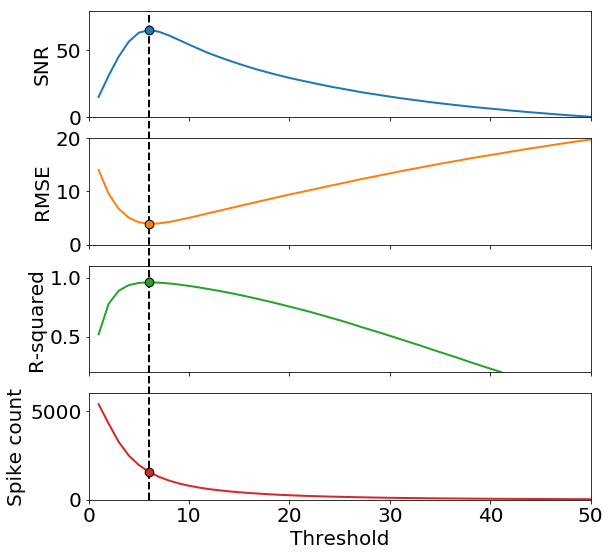

In [87]:
# best = 6
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
# # fig.suptitle('SF Encoding')
# x = range(1,51)
# y1 = [np.mean(x) for x in SNR]
# ax1.plot(x, y1, 'tab:blue', lw=2)
# ax1.set_ylabel('SNR')
# ax1.set_xlim([0,50])
# ax1.set_ylim([0,80])
# ax1.scatter(best, y1[best-1], c='tab:blue', zorder=4, s = 75, edgecolors='black')
# ax1.axvline(x=best, ymin=-1.2, ymax=1, c='black', ls = '--', lw=2, zorder=0, clip_on=False)
# y2 = [np.mean(x) for x in RMSE]
# ax2.plot(x, y2, 'tab:orange', lw=2)
# ax2.set_ylabel('RMSE')
# ax2.set_xlim([0,50])
# ax2.set_ylim([0,20])
# ax2.scatter(best, y2[best-1], c='tab:orange', zorder=4, s = 75, edgecolors='black')
# ax2.axvline(x=best, ymin=-1.2, ymax=1, c='black', ls = '--', lw=2, zorder=0, clip_on=False)
# y3 = [np.mean(x) for x in R2]
# ax3.plot(x, y3, 'tab:green', lw=2)
# ax3.set_ylabel('R-squared')
# ax3.set_xlim([0,50])
# ax3.set_ylim([0.2,1.1])
# ax3.scatter(best, y3[best-1], c='tab:green', zorder=4, s = 75, edgecolors='black')
# ax3.axvline(x=best, ymin=-1.2, ymax=1, c='black', ls = '--', lw=2, zorder=0, clip_on=False)
# y4 = [np.mean(x) for x in AFR]
# ax4.plot(x, y4, 'tab:red', lw=2)
# ax4.set_ylabel('Spike count')
# ax4.set_xlabel('Threshold')
# ax4.set_xlim([0,50])
# ax4.set_ylim([0,6000])
# ax4.scatter(best, y4[best-1], c='tab:red', zorder=4, s = 75, edgecolors='black')
# ax4.axvline(x=best, ymin=0, ymax=1, c='black', ls = '--', lw=2, zorder=0, clip_on=False)

# for ax in fig.get_axes():
#     ax.label_outer()
    
# # plt.savefig('SFmetrics_new.png')
